In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

from lsst.daf.butler import Butler
from lsst.pipe.base import Instrument
import lsst.afw.cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, FIELD_ANGLE


# Code to get QE information from the LSSTCam Instrument

In [4]:
_ = Butler.makeRepo("lsstcam_test_repo")

butler = Butler("lsstcam_test_repo", writeable=True)
instr = Instrument.from_string("lsst.obs.lsst.LsstCam")
instr.register(butler.registry)
instr.writeCuratedCalibrations(butler)

camera = butler.get("camera", instrument="LSSTCam", collections=...)

In [5]:
!ls lsstcam_test_repo/LSSTCam/calib/curated/*/transmission_sensor/*R11_S11*

lsstcam_test_repo/LSSTCam/calib/curated/19700101T000000Z/transmission_sensor/transmission_sensor_LSSTCam_R11_S11_LSSTCam_calib_curated_19700101T000000Z.fits


In [6]:
hdu = fits.open('lsstcam_test_repo/LSSTCam/calib/curated/19700101T000000Z/transmission_sensor/transmission_sensor_LSSTCam_R11_S11_LSSTCam_calib_curated_19700101T000000Z.fits')
hdu.info()

Filename: lsstcam_test_repo/LSSTCam/calib/curated/19700101T000000Z/transmission_sensor/transmission_sensor_LSSTCam_R11_S11_LSSTCam_calib_curated_19700101T000000Z.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  ARCHIVE_INDEX    1 BinTableHDU     41   1R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  2  SpatiallyConstantTransmissionCurve    1 BinTableHDU     30   1R x 4C   [1D, 1D, 1QD(7), 1QD(7)]   


In [7]:
print(hdu[1].data)

[(1, 1, 0, 0, 1, 'SpatiallyConstantTransmissionCurve', 'lsst.afw.image')]


In [8]:
print(hdu[2].data.columns)
print(hdu[2].data)
print(hdu[2].data['throughput'])
print(hdu[2].data['wavelengths'])

ColDefs(
    name = 'throughputAtMin'; format = '1D'
    name = 'throughputAtMax'; format = '1D'
    name = 'throughput'; format = '1QD(7)'
    name = 'wavelengths'; format = '1QD(7)'; unit = 'angstrom'
)
[(0., 0., [0, 0, 0, 0, 0, 0, 0], [3499, 4500, 5000, 6199, 7500, 8699, 9999])]
[array([0.72908479, 0.86512518, 0.90641272, 0.97010344, 0.96969086,
        0.89861542, 0.26638383])                                   ]
[array([3499.81982422, 4500.35009766, 5000.18017578, 6199.97021484,
        7500.21972656, 8699.66992188, 9999.75976562])              ]


In [9]:
hduc = fits.open('lsstcam_test_repo/LSSTCam/calib/unbounded/camera/camera_LSSTCam_LSSTCam_calib_unbounded.fits')
hduc.info()

Filename: lsstcam_test_repo/LSSTCam/calib/unbounded/camera/camera_LSSTCam_LSSTCam_calib_unbounded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  ARCHIVE_INDEX    1 BinTableHDU     41   824R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  2  Camera        1 BinTableHDU     17   205R x 1C   [1J]   
  3  Detector      1 BinTableHDU    115   205R x 22C   [1QA(7), 1J, 1J, 1QA(14), 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1QE(0), 1QA(6), 1J]   
  4  TransformMap    1 BinTableHDU     33   411R x 5C   [1QA(10), 1QA(7), 1QA(10), 1QA(7), 1J]   
  5  TransformPoint2ToPoint2    1 BinTableHDU     17   411R x 1C   [1QB(3288)]   
  6  Detector      1 BinTableHDU    200   3216R x 38C   [3X, 1QA(3), 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1J, 1QD(2), 1QA(12), 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1D, 1D, 1QA(2)]   
  7  Camera        1 BinTableHDU     25   1R x 3C   [1QA(7

In [10]:
def get_qe_lsstcam(det_num,camera,bulter):

    detector = camera[det_num]

    qe = butler.get("transmission_sensor", detector=det_num, instrument="LSSTCam", collections=...)

    lambdas = np.linspace(
        qe.getWavelengthBounds()[0],
        qe.getWavelengthBounds()[1],
        1000)

    cent = detector.getCenter(lsst.afw.cameraGeom.FOCAL_PLANE)

    qe_values = qe.sampleAt(position=cent, wavelengths=lambdas)
    return lambdas/10.,qe_values

In [11]:
det_names = {i: det.getName() for i, det in enumerate(camera)}
det_ptype = {i: det.getPhysicalType() for i, det in enumerate(camera)}

def get_allrtmtype():
    rtm_type = {'R00':'corner','R01':'itl','R02':'itl','R03':'itl','R04':'corner',
                'R10':'itl','R11':'e2v','R12':'e2v','R13':'e2v','R14':'e2v',
                'R20':'itl','R21':'e2v','R22':'e2v','R23':'e2v','R24':'e2v',
                'R30':'e2v','R31':'e2v','R32':'e2v','R33':'e2v','R34':'e2v',
                'R40':'corner','R41':'itl','R42':'itl','R43':'itl','R44':'corner'}
    return rtm_type

# can use det.getPhysicalType()  to return E2V,ITL,ITL_G,ITL_WF

rtmtypes = get_allrtmtype()

In [12]:
adet = camera[29]
print(adet.getName())
print(adet.getPhysicalType())
print(adet.getId())
print(f"{adet.getCenter(FIELD_ANGLE) = } (radians)")
print(f"{adet.getCenter(FOCAL_PLANE) = } (mm)")
print(adet.getCorners(FOCAL_PLANE))
print(adet.getBBox())

# corners
corners = adet.getCorners(FOCAL_PLANE)
print("Lower left is corner[0] ",corners[0])
print("Lower right is corner[1] ",corners[1])
print("Upper left is corner[2] ",corners[2])
print("Upper right is corner[3] ",corners[3])

R10_S02
ITL
29
adet.getCenter(FIELD_ANGLE) = Point2D(-0.020532829022351071, -0.016411912732920014) (radians)
adet.getCenter(FOCAL_PLANE) = Point2D(-211.76000000000002, -169.25999999999999) (mm)
[Point2D(-232.12, -189.25999999999999), Point2D(-191.40000000000001, -189.25999999999999), Point2D(-191.40000000000001, -149.25999999999999), Point2D(-232.12, -149.25999999999999)]
(minimum=(0, 0), maximum=(4071, 3999))
Lower left is corner[0]  (-232.12, -189.26)
Lower right is corner[1]  (-191.4, -189.26)
Upper left is corner[2]  (-191.4, -149.26)
Upper right is corner[3]  (-232.12, -149.26)


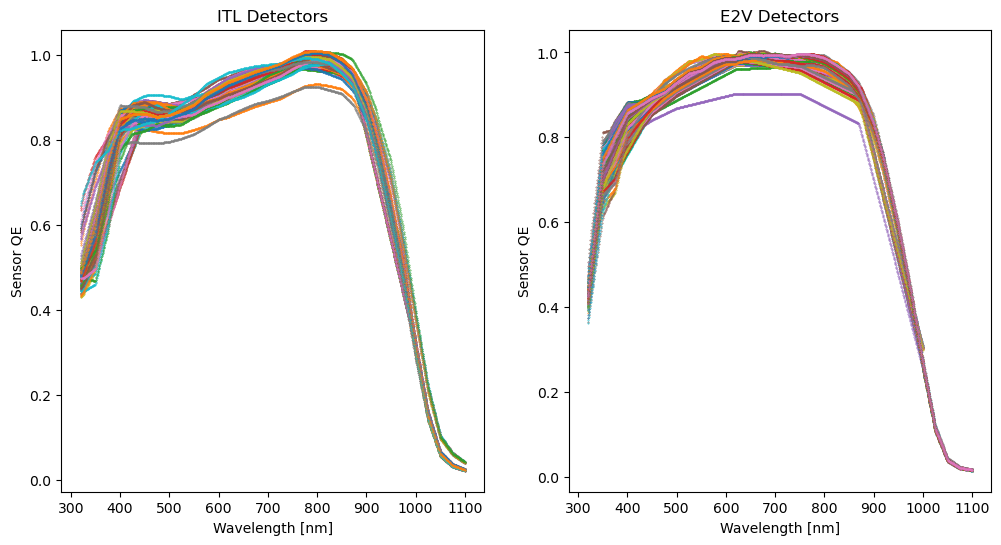

In [13]:
f,ax = plt.subplots(1,2,figsize=(12,6))

sensor_types = ['ITL','E2V']
for i,aptype in enumerate(sensor_types):
    for det in camera:
    
        det_name = det.getName()
        ptype = det.getPhysicalType()
        idet = det.getId()
        det_name = det_names[idet]
        if ptype == aptype:
            lambdas,qe_values = get_qe_lsstcam(idet,camera,butler)
            h = ax[i].scatter(lambdas, qe_values, marker='.',s=0.5)
            ax[i].set_xlabel("Wavelength [nm]")
            ax[i].set_ylabel("Sensor QE")
            ax[i].set_title("%s Detectors"%(aptype))

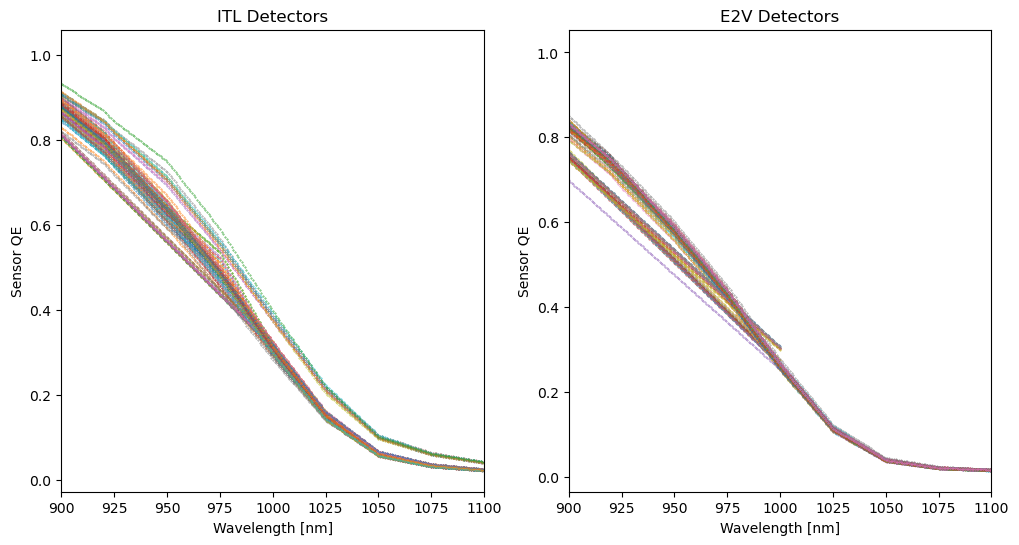

In [14]:
f,ax = plt.subplots(1,2,figsize=(12,6))

sensor_types = ['ITL','E2V']
for i,aptype in enumerate(sensor_types):
    for det in camera:
    
        det_name = det.getName()
        ptype = det.getPhysicalType()
        idet = det.getId()
        det_name = det_names[idet]
        if ptype == aptype:
            lambdas,qe_values = get_qe_lsstcam(idet,camera,butler)
            h = ax[i].scatter(lambdas, qe_values, marker='.',s=0.5)
            ax[i].set_xlim(900.,1100.)
            ax[i].set_xlabel("Wavelength [nm]")
            ax[i].set_ylabel("Sensor QE")
            ax[i].set_title("%s Detectors"%(aptype))

# dump all data to a DF

In [23]:
qedict = {}
idet = []
bayslot = []
waves = []
qes = []

for i,det in enumerate(camera):
    det_name = det.getName()
    det_ptype = det.getPhysicalType()
    if det_ptype=='E2V' or det_ptype=='ITL':
        hdu = fits.open('lsstcam_test_repo/LSSTCam/calib/curated/19700101T000000Z/transmission_sensor/transmission_sensor_LSSTCam_%s_LSSTCam_calib_curated_19700101T000000Z.fits'%(det_name))
    
        tput_arr = hdu[2].data['throughput']   # returned as a 1 element array
        waves_arr = hdu[2].data['wavelengths']
        
        idet.append(i)
        bayslot.append(det_name)
        waves.append(waves_arr[0]/10.)  # convert from Angstroms to nm
        qes.append(tput_arr[0])
        
qedict['idet'] = idet
qedict['bayslot'] = bayslot
qedict['wl'] = waves
qedict['qe'] = np.array(qes)*100.  # convert to percent!

df = pd.DataFrame(qedict)
df.set_index('idet')
            

/tmp/ipykernel_11504/132524236.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qedict['qe'] = np.array(qes)*100.  # convert to percent!


,bayslot,wl,qe
idet,,,
0,R01_S00,"[319.993994140625, 324.968994140625, 349.98198...","[48.62901270389557, 50.684475898742676, 61.073..."
1,R01_S01,"[319.993994140625, 324.968994140625, 349.98198...","[43.77663433551788, 44.71161663532257, 51.1192..."
2,R01_S02,"[319.993994140625, 324.968994140625, 349.98198...","[49.374938011169434, 51.396119594573975, 61.52..."
3,R01_S10,"[319.993994140625, 324.968994140625, 349.98198...","[49.032485485076904, 51.22615694999695, 62.138..."
4,R01_S11,"[319.993994140625, 324.968994140625, 349.98198...","[50.256162881851196, 52.67104506492615, 64.050..."
...,...,...,...
184,R43_S11,"[319.993994140625, 324.968994140625, 349.98198...","[51.53786540031433, 53.83468270301819, 65.3503..."
185,R43_S12,"[319.993994140625, 324.968994140625, 349.98198...","[50.58000087738037, 52.93895602226257, 64.5089..."
186,R43_S20,"[319.993994140625, 324.968994140625, 349.98198...","[64.72468972206116, 67.41368174552917, 74.7405..."


In [24]:
print(df['qe'][0])
print(df['wl'][0])

[48.6290127  50.6844759  61.07317805 74.81709123 84.35157537 84.91258025
 84.1763258  84.05234218 84.50753689 85.46731472 87.11109757 88.88055086
 91.03966951 91.94408059 92.28781462 93.77911091 94.97087002 95.69808245
 96.45730853 97.86846638 99.14556742 99.36497211 98.33862782 96.91867828
 94.34626698 93.31799746 86.25853062 77.83949971 75.13531446 62.353158
 47.68081605 30.70992827 14.86059427  5.90679534  3.34224328  2.31050104]
[ 319.99399414  324.96899414  349.98198242  374.975       400.01901855
  424.96499023  450.03500977  475.00297852  500.01801758  525.00200195
  550.02900391  575.02299805  599.98198242  619.99702148  624.97900391
  650.01201172  675.00400391  700.0300293   725.01201172  750.02197266
  774.98701172  799.97602539  824.98798828  850.02197266  869.96699219
  875.00205078  899.99902344  919.99902344  925.01201172  949.96503906
  975.00205078  999.97597656 1025.02792969 1050.0140625  1075.00195312
 1099.99003906]


In [25]:
print(df)

     idet  bayslot                                                 wl  \
0       0  R01_S00  [319.993994140625, 324.968994140625, 349.98198...   
1       1  R01_S01  [319.993994140625, 324.968994140625, 349.98198...   
2       2  R01_S02  [319.993994140625, 324.968994140625, 349.98198...   
3       3  R01_S10  [319.993994140625, 324.968994140625, 349.98198...   
4       4  R01_S11  [319.993994140625, 324.968994140625, 349.98198...   
..    ...      ...                                                ...   
184   184  R43_S11  [319.993994140625, 324.968994140625, 349.98198...   
185   185  R43_S12  [319.993994140625, 324.968994140625, 349.98198...   
186   186  R43_S20  [319.993994140625, 324.968994140625, 349.98198...   
187   187  R43_S21  [319.993994140625, 324.968994140625, 349.98198...   
188   188  R43_S22  [319.993994140625, 324.968994140625, 349.98198...   

                                                    qe  
0    [48.62901270389557, 50.684475898742676, 61.073...  
1    [43.

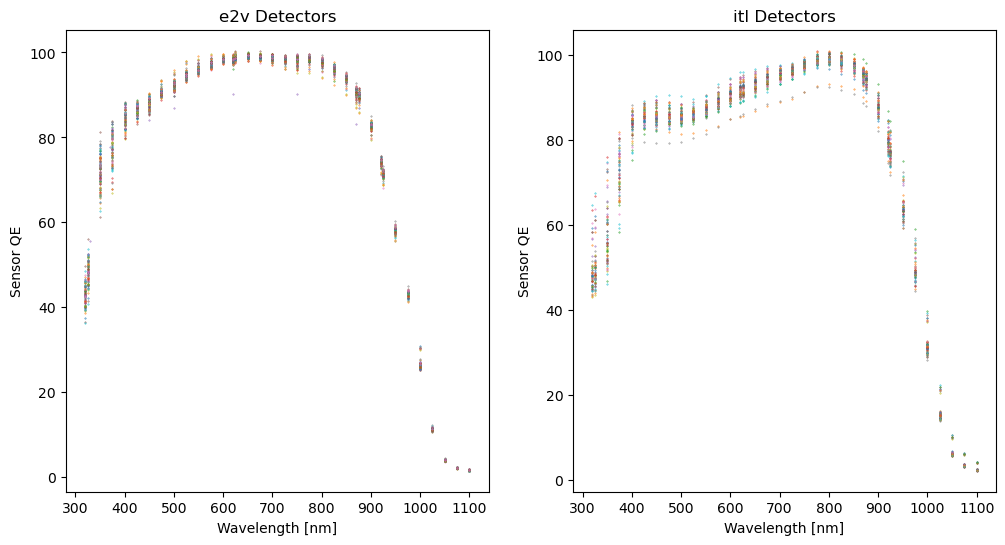

In [26]:
f,ax = plt.subplots(1,2,figsize=(12,6))

types = ['e2v','itl']
for i,atype in enumerate(types):
    for idet in range(205):
    
        det_name = det_names[idet]
        bay = det_name[0:3]
        rtmtype = rtmtypes[bay]
        if rtmtype == atype:
            lambdas = df['wl'][idet]
            qe_values = df['qe'][idet]
            h = ax[i].scatter(lambdas, qe_values, marker='.',s=0.5)

    ax[i].set_xlabel("Wavelength [nm]")
    ax[i].set_ylabel("Sensor QE")
    ax[i].set_title('%s Detectors'%(atype))

In [27]:
df.to_parquet('qe_dm_values.parquet')

## check idet=117

In [28]:
idet=117
lambdas,qe_values = get_qe_lsstcam(idet,camera,butler)
print(qe_values)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

## Ok! DM has nan's for idet=117 R30_S00.  This sensor had one amp that was non-functional with nans in the eTraveler, evidently that did not get fixed

# study DE at 1020 and 1050nm